<a href="https://colab.research.google.com/github/Badar-Islam/Driver_churn/blob/main/Cab_Company_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cab Company - Ensemble Learning:
### Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### What is Expected?
Assuming you are a data scientist at Ola, you are entrusted with the responsibility ofanalyzing the dataset to predict driver attrition. Your primary goal is to utilize ensemble
learning techniques, evaluate the performance of your models, and provide actionable insights to reduce driver churn

### Column Profiling:
1.	**MMMM-YY** : Reporting Date (Monthly)
2.	**Driver_ID** : Unique id for drivers
3.	**Age** : Age of the driver
4.	**Gender** : Gender of the driver – Male : 0, Female: 1
5.	**City** : City Code of the driver
6.	**Education_Level** : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7.	**Income** : Monthly average Income of the driver
8.	**Date Of Joining** : Joining date for the driver
9.	**LastWorkingDate** : Last date of working for the driver
10.	**Joining Designation** : Designation of the driver at the time of joining
11.	**Grade** : Grade of the driver at the time of reporting
12.	**Total** Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13.	**Quarterly Rating** : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve,
      confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay)

In [ ]:
!gdown 1mTo3Hz_O0I4YjS70eKzdfXpBX4LT9J5C

Downloading...
From: https://drive.google.com/uc?id=1mTo3Hz_O0I4YjS70eKzdfXpBX4LT9J5C
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 18.5MB/s]


In [ ]:
df = pd.read_csv('ola_driver_scaler.csv')
ola = df.copy()
ola.head()


Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1

In [ ]:
ola.shape

(19104, 14)

#### Insights:
- There are 19104 records and 14 columns present in the dataset.


## Exploratory Data Analysis:

In [ ]:
ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


#### Insights:
- `Unnamed: 0` column doesn't hold any significance and can be dropped.
- Columns like `MMM-YY`, `Dateofjoining` and `LastWorkingDate` can be converted to date columns.
- Columns like `Driver_ID`, `Gender`, `Education_Level`, `Grade` and `Joining Designation` can be converted to object class for better data analysis insights.

In [ ]:
ola.drop(columns=['Unnamed: 0'], inplace=True)
ola['MMM-YY'] = pd.to_datetime(ola['MMM-YY'])
ola['Dateofjoining'] = pd.to_datetime(ola['Dateofjoining'])
ola['LastWorkingDate'] = pd.to_datetime(ola['LastWorkingDate'])
ola['Driver_ID'] = ola['Driver_ID'].astype('object')
ola['Gender'] = ola['Gender'].astype('object')
ola['Education_Level'] = ola['Education_Level'].astype('object')
ola['Grade'] = ola['Grade'].astype('object')
ola['Joining Designation'] = ola['Joining Designation'].astype('object')
ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  object        
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  object        
 10  Grade                 19104 non-null  object        
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [ ]:
ola.describe().T

count                           mean  \
MMM-YY                  19104  2019-12-11 02:09:29.849246464   
Age                   19043.0                      34.668435   
Income                19104.0                   65652.025126   
Dateofjoining           19104  2018-04-28 20:52:54.874371840   
LastWorkingDate          1616  2019-12-21 20:59:06.534653696   
Total Business Value  19104.0                  571662.074958   
Quarterly Rating      19104.0                       2.008899   

                                      min                  25%  \
MMM-YY                2019-01-01 00:00:00  2019-06-01 00:00:00   
Age                                  21.0                 30.0   
Income                            10747.0              42383.0   
Dateofjoining         2013-04-01 00:00:00  2016-11-29 12:00:00   
LastWorkingDate       2018-12-31 00:00:00  2019-06-06 00:00:00   
Total Business Value           -6000000.0                  0.0   
Quarterly Rating                      1.0                  1.0   

                                      50%                  75%  \
MMM-YY                2019-12-01 00:00:00  2020-07-01 00:00:00   
Age                                  34.0                 39.0   
Income                            60087.0              83969.0   
Dateofjoining         2018-09-12 00:00:00  2019-11-05 00:00:00   
LastWorkingDate       2019-12-20 12:00:00  2020-07-03 00:00:00   
Total Business Value             250000.0             699700.0   
Quarterly Rating                      2.0                  3.0   

                                      max             std  
MMM-YY                2020-12-01 00:00:00             NaN  
Age                                  58.0        6.257912  
Income                           188418.0    30914.515344  
Dateofjoining         2020-12-28 00:00:00             NaN  
LastWorkingDate       2020-12-28 00:00:00             NaN  
Total Business Value           33747720.0  1128312.218461  
Quarterly Rating                      4.0        1.009832

#### Insights:
- The average age of individuals is 34.67 years, with most people between 30 and 39 years old. The range spans from 21 to 58 years, suggesting the population is largely working-age adults.
- The median date of joining is around September 2018, with 75% of the workforce joining by late 2019, which implies a majority have relatively recent employment histories (3–4 years).
- Of those who have left (1616 individuals), the median exit date is December 2019. The last working date trends suggest a high turnover during 2019-2020.
- The average income is 65,652, with a median of 60,087. There’s considerable variation, as indicated by a standard deviation of 30,914. The income spread is quite wide, from a minimum of 10,747 to a maximum of 188,418.
- The high variability in business value, with some extreme negative and positive cases, suggests an uneven distribution of impact across the workforce.
- With a median rating of 2, the performance distribution skews toward average, with few high performers.

In [ ]:
ola.describe(include='object').T

count unique   top     freq
Driver_ID              19104   2381  2110       24
Gender               19052.0    2.0   0.0  11074.0
City                   19104     29   C20     1008
Education_Level        19104      3     1     6864
Joining Designation    19104      5     1     9831
Grade                  19104      5     2     6627

#### Insights:
- There are 2381 unique drivers out of 19,104 entries, meaning many drivers appear multiple times in the dataset. The most frequent driver (ID 2110) has 24 occurrences, indicating repeated records or involvement in multiple transactions for certain drivers.
- The most frequent value is 0(male), which appears 11,074 times out of 19,052 valid entries, suggesting that the majority of drivers are likely male.
- There are 29 unique cities in the dataset. The city labeled "C20" appears 1,008 times, indicating it is the most common location, with a high concentration of drivers or transactions originating from there.
- There are three unique education levels. The most common level coded as 1 (12+ or mid level education) appears 6,864 times, which could suggest that the majority of drivers have a mid level education.
- There are five unique joining designations, with the most common one (coded as 1) appearing 9,831 times. This shows that more than half of the drivers started their employment with the same designation, indicating a concentration in a particular role or rank at the time of joining.
- The dataset includes five unique grades, with the most frequent grade (coded as 2) appearing 6,627 times. This suggests a hierarchy where grade 2 is the most common level among drivers, potentially indicating that a significant proportion of the workforce operates at a mid-tier level.

In [ ]:
for col in ola.select_dtypes(include='object').columns:
  print(ola[col].value_counts())
  print('-'*50)

Driver_ID
2110    24
2617    24
1623    24
1642    24
1644    24
        ..
1614     1
445      1
2397     1
1619     1
469      1
Name: count, Length: 2381, dtype: int64
--------------------------------------------------
Gender
0.0    11074
1.0     7978
Name: count, dtype: int64
--------------------------------------------------
City
C20    1008
C29     900
C26     869
C22     809
C27     786
C15     761
C10     744
C12     727
C8      712
C16     709
C28     683
C1      677
C6      660
C5      656
C14     648
C3      637
C24     614
C7      609
C21     603
C25     584
C19     579
C4      578
C13     569
C18     544
C23     538
C9      520
C2      472
C11     468
C17     440
Name: count, dtype: int64
--------------------------------------------------
Education_Level
1    6864
2    6327
0    5913
Name: count, dtype: int64
--------------------------------------------------
Joining Designation
1    9831
2    5955
3    2847
4     341
5     130
Name: count, dtype: int64
-------------------

## Feature Engineering:


In [ ]:
# Checking for which drivers there are either zero or negative business value at some point
ola['Negative_Total_Business_Value'] = np.where(ola['Total Business Value']<0, 1, 0)
ola['Zero_Total_Business_Value'] = np.where(ola['Total Business Value']==0, 1, 0)

# Checking how many drivers churned
ola['Churned'] = np.where(ola['LastWorkingDate'].isna(), 0, 1)

In [ ]:
ola.head()

MMM-YY Driver_ID   Age Gender City Education_Level  Income  \
0 2019-01-01         1  28.0    0.0  C23               2   57387   
1 2019-02-01         1  28.0    0.0  C23               2   57387   
2 2019-03-01         1  28.0    0.0  C23               2   57387   
3 2020-11-01         2  31.0    0.0   C7               2   67016   
4 2020-12-01         2  31.0    0.0   C7               2   67016   

  Dateofjoining LastWorkingDate Joining Designation Grade  \
0    2018-12-24             NaT                   1     1   
1    2018-12-24             NaT                   1     1   
2    2018-12-24      2019-03-11                   1     1   
3    2020-11-06             NaT                   2     2   
4    2020-11-06             NaT                   2     2   

   Total Business Value  Quarterly Rating  Negative_Total_Business_Value  \
0               2381060                 2                              0   
1               -665480                 2                              1   
2                     0                 2                              0   
3                     0                 1                              0   
4                     0                 1                              0   

   Zero_Total_Business_Value  Churned  
0                          0        0  
1                          0        0  
2                          1        1  
3                          1        0  
4                          1        0

In [ ]:
create_segment_dict = {
    #'Driver_ID':'first',
    'MMM-YY':'first',
    'Age':'max',
    'Gender':'first',
    'City':'first',
    'Education_Level':'max',
    'Income':'mean',
    'Dateofjoining':'first',
    'LastWorkingDate':'last',
    'Joining Designation':'max',
    'Grade':'max',
    'Total Business Value':'sum',
    'Quarterly Rating':'median',
    'Negative_Total_Business_Value':'sum',
    'Zero_Total_Business_Value':'sum',
    'Churned':'max'
}

In [ ]:
segment = ola.groupby('Driver_ID').agg(create_segment_dict).reset_index()
segment.shape

(2381, 16)

In [ ]:
segment['Driver_ID'] = segment['Driver_ID'].astype('object')
seg_cat_col = segment.select_dtypes(include='object').columns
seg_num_col = segment.select_dtypes(exclude='object').columns
seg_cat_col, seg_num_col

(Index(['Driver_ID', 'Gender', 'City', 'Education_Level', 'Joining Designation',
        'Grade'],
       dtype='object'),
 Index(['MMM-YY', 'Age', 'Income', 'Dateofjoining', 'LastWorkingDate',
        'Total Business Value', 'Quarterly Rating',
        'Negative_Total_Business_Value', 'Zero_Total_Business_Value',
        'Churned'],
       dtype='object'))

In [ ]:
for col in seg_cat_col[1:]:
  print(segment[col].value_counts())
  print('-'*50)

Gender
0.0    1404
1.0     977
Name: count, dtype: int64
--------------------------------------------------
City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C5      80
C1      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C25     74
C23     74
C24     73
C19     72
C2      72
C17     71
C13     71
C18     69
C11     64
Name: count, dtype: int64
--------------------------------------------------
Education_Level
2    802
1    795
0    784
Name: count, dtype: int64
--------------------------------------------------
Joining Designation
1    1026
2     815
3     493
4      36
5      11
Name: count, dtype: int64
--------------------------------------------------
Grade
2    854
1    741
3    624
4    138
5     24
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
print(segment['Quarterly Rating'].value_counts())
print('-'*50)
print(segment['Negative_Total_Business_Value'].value_counts())
print('-'*50)
print(segment['Zero_Total_Business_Value'].value_counts())

Quarterly Rating
1.0    1397
2.0     537
3.0     256
1.5      67
4.0      56
2.5      51
3.5      17
Name: count, dtype: int64
--------------------------------------------------
Negative_Total_Business_Value
0    2245
1     125
2       9
3       2
Name: count, dtype: int64
--------------------------------------------------
Zero_Total_Business_Value
2     533
1     520
3     474
4     350
5     210
0     148
6      70
7      39
8      15
9       8
10      6
11      5
12      1
15      1
14      1
Name: count, dtype: int64


In [ ]:
ola['Quarter'] = ola['MMM-YY'].dt.to_period('Q')
quarterly_total_business_value = ola.groupby(['Driver_ID', 'Quarter'])['Total Business Value'].sum().reset_index().sort_values(by='Total Business Value', ascending=False)
quarterly_total_business_value

Driver_ID Quarter  Total Business Value
6595       2522  2020Q4              32442880
6588       2522  2019Q1              30592070
4226       1638  2020Q1              27923960
5474       2114  2020Q4              26631040
3069       1181  2019Q1              25468650
...         ...     ...                   ...
4660       1803  2019Q1               -900620
2044        787  2020Q2              -1308240
887         355  2019Q2              -1599980
3540       1354  2019Q3              -1651710
6398       2455  2019Q4              -2445930

[7357 rows x 3 columns]

In [ ]:
ola = ola.sort_values(by='MMM-YY')

# Calculate the count of Drivers with increased Quarterly Rating
inc_quarterly_rating = ola.groupby(['Driver_ID'])['Quarterly Rating'].apply(lambda x: int(x.iloc[-1] > x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Inc_Quarterly_Rating')
segment = pd.merge(segment, inc_quarterly_rating, on='Driver_ID', how='outer')

# Calculate the count of Drivers with decreased Quarterly Rating
dec_quarterly_rating = ola.groupby(['Driver_ID'])['Quarterly Rating'].apply(lambda x: int(x.iloc[-1] < x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Dec_Quarterly_Rating')
segment = pd.merge(segment, dec_quarterly_rating, on='Driver_ID', how='outer')

print(segment['Inc_Quarterly_Rating'].value_counts())
print('-'*50)
print(segment['Dec_Quarterly_Rating'].value_counts())

Inc_Quarterly_Rating
0    2074
1     307
Name: count, dtype: int64
--------------------------------------------------
Dec_Quarterly_Rating
0    1874
1     507
Name: count, dtype: int64


In [ ]:
# Calculate the count of Drivers with increased income:
inc_income = ola.groupby(['Driver_ID'])['Income'].apply(lambda x: int(x.iloc[-1] > x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Inc_Income')
segment = pd.merge(segment, inc_income, on='Driver_ID', how='outer')

# Calculate the count of Drivers with decreased income:
dec_income = ola.groupby(['Driver_ID'])['Income'].apply(lambda x: int(x.iloc[-1] < x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Dec_Income')
segment = pd.merge(segment, dec_income, on='Driver_ID', how='outer')

print(segment['Inc_Income'].value_counts())
print('-'*50)
print(segment['Dec_Income'].value_counts())

Inc_Income
0    2338
1      43
Name: count, dtype: int64
--------------------------------------------------
Dec_Income
0    2381
Name: count, dtype: int64


In [ ]:
# Calculate the count of drivers with improved Grade
improved_grade = ola.groupby(['Driver_ID'])['Grade'].apply(lambda x: int(x.iloc[-1] > x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Improved_Grade')
segment = pd.merge(segment, improved_grade, on='Driver_ID', how='outer')

# Calculate the count of drivers with decreased Grade
decreased_grade = ola.groupby(['Driver_ID'])['Grade'].apply(lambda x: int(x.iloc[-1] < x.iloc[1]) if len(x) >=2 else 0).reset_index(name='Decreased_Grade')
segment = pd.merge(segment, decreased_grade, on='Driver_ID', how='outer')

print(segment['Improved_Grade'].value_counts())
print('-'*50)
print(segment['Decreased_Grade'].value_counts())

Improved_Grade
0    2338
1      43
Name: count, dtype: int64
--------------------------------------------------
Decreased_Grade
0    2381
Name: count, dtype: int64


In [ ]:
segment.drop(columns=['Decreased_Grade', 'Dec_Income'], inplace=True)
segment.head()

Driver_ID     MMM-YY   Age Gender City Education_Level   Income  \
0         1 2019-01-01  28.0    0.0  C23               2  57387.0   
1         2 2020-11-01  31.0    0.0   C7               2  67016.0   
2         4 2019-12-01  43.0    0.0  C13               2  65603.0   
3         5 2019-01-01  29.0    0.0   C9               0  46368.0   
4         6 2020-08-01  31.0    1.0  C11               1  78728.0   

  Dateofjoining LastWorkingDate Joining Designation Grade  \
0    2018-12-24      2019-03-11                   1     1   
1    2020-11-06             NaT                   2     2   
2    2019-12-07      2020-04-27                   2     2   
3    2019-01-09      2019-03-07                   1     1   
4    2020-07-31             NaT                   3     3   

   Total Business Value  Quarterly Rating  Negative_Total_Business_Value  \
0               1715580               2.0                              1   
1                     0               1.0                              0   
2                350000               1.0                              0   
3                120360               1.0                              0   
4               1265000               2.0                              0   

   Zero_Total_Business_Value  Churned  Inc_Quarterly_Rating  \
0                          1        1                     0   
1                          2        0                     0   
2                          4        1                     0   
3                          2        1                     0   
4                          4        0                     1   

   Dec_Quarterly_Rating  Inc_Income  Improved_Grade  
0                     0           0               0  
1                     0           0               0  
2                     0           0               0  
3                     0           0               0  
4                     0           0               0

In [ ]:
# Calculate the cost-to-income ratio to check whether the business is generating enough money to cover its costs
lifetime_income = ola.groupby('Driver_ID')['Income'].sum().reset_index(name='Lifetime_Income')
segment = pd.merge(segment, lifetime_income, on='Driver_ID', how='outer')
segment['Cost_To_Income_Ratio'] = segment['Total Business Value'] / segment['Lifetime_Income']

# column renaming for better reference
segment.rename(columns={'Income':'Avg_Income'}, inplace=True)
segment.head()

Driver_ID     MMM-YY   Age Gender City Education_Level  Avg_Income  \
0         1 2019-01-01  28.0    0.0  C23               2     57387.0   
1         2 2020-11-01  31.0    0.0   C7               2     67016.0   
2         4 2019-12-01  43.0    0.0  C13               2     65603.0   
3         5 2019-01-01  29.0    0.0   C9               0     46368.0   
4         6 2020-08-01  31.0    1.0  C11               1     78728.0   

  Dateofjoining LastWorkingDate Joining Designation  ... Quarterly Rating  \
0    2018-12-24      2019-03-11                   1  ...              2.0   
1    2020-11-06             NaT                   2  ...              1.0   
2    2019-12-07      2020-04-27                   2  ...              1.0   
3    2019-01-09      2019-03-07                   1  ...              1.0   
4    2020-07-31             NaT                   3  ...              2.0   

   Negative_Total_Business_Value  Zero_Total_Business_Value  Churned  \
0                              1                          1        1   
1                              0                          2        0   
2                              0                          4        1   
3                              0                          2        1   
4                              0                          4        0   

   Inc_Quarterly_Rating  Dec_Quarterly_Rating  Inc_Income  Improved_Grade  \
0                     0                     0           0               0   
1                     0                     0           0               0   
2                     0                     0           0               0   
3                     0                     0           0               0   
4                     1                     0           0               0   

   Lifetime_Income  Cost_To_Income_Ratio  
0           172161              9.964975  
1           134032              0.000000  
2           328015              1.067024  
3           139104              0.865252  
4           393640              3.213596  

[5 rows x 22 columns]

In [ ]:
#segment.to_csv('segment.csv', index=False)

In [ ]:
segment.describe().T

count                           mean  \
MMM-YY                           2381  2019-08-30 15:12:37.496849920   
Age                            2381.0                      33.663167   
Avg_Income                     2381.0                   59232.460484   
Dateofjoining                    2381  2019-02-08 07:14:50.550189056   
LastWorkingDate                  1616  2019-12-21 20:59:06.534653440   
Total Business Value           2381.0                 4586741.822764   
Quarterly Rating               2381.0                       1.575178   
Negative_Total_Business_Value  2381.0                       0.062579   
Zero_Total_Business_Value      2381.0                       2.729525   
Churned                        2381.0                       0.678706   
Inc_Quarterly_Rating           2381.0                       0.128937   
Dec_Quarterly_Rating           2381.0                       0.212936   
Inc_Income                     2381.0                        0.01806   
Improved_Grade                 2381.0                        0.01806   
Lifetime_Income                2381.0                  526760.305754   
Cost_To_Income_Ratio           2381.0                       5.350189   

                                               min                  25%  \
MMM-YY                         2019-01-01 00:00:00  2019-01-01 00:00:00   
Age                                           21.0                 29.0   
Avg_Income                                 10747.0              39104.0   
Dateofjoining                  2013-04-01 00:00:00  2018-06-29 00:00:00   
LastWorkingDate                2018-12-31 00:00:00  2019-06-06 00:00:00   
Total Business Value                    -1385530.0                  0.0   
Quarterly Rating                               1.0                  1.0   
Negative_Total_Business_Value                  0.0                  0.0   
Zero_Total_Business_Value                      0.0                  1.0   
Churned                                        0.0                  0.0   
Inc_Quarterly_Rating                           0.0                  0.0   
Dec_Quarterly_Rating                           0.0                  0.0   
Inc_Income                                     0.0                  0.0   
Improved_Grade                                 0.0                  0.0   
Lifetime_Income                            10883.0             139895.0   
Cost_To_Income_Ratio                     -7.388906                  0.0   

                                               50%                  75%  \
MMM-YY                         2019-07-01 00:00:00  2020-05-01 00:00:00   
Age                                           33.0                 37.0   
Avg_Income                                 55285.0              75835.0   
Dateofjoining                  2019-07-21 00:00:00  2020-05-02 00:00:00   
LastWorkingDate                2019-12-20 12:00:00  2020-07-03 00:00:00   
Total Business Value                      817680.0            4173650.0   
Quarterly Rating                               1.0                  2.0   
Negative_Total_Business_Value                  0.0                  0.0   
Zero_Total_Business_Value                      2.0                  4.0   
Churned                                        1.0                  1.0   
Inc_Quarterly_Rating                           0.0                  0.0   
Dec_Quarterly_Rating                           0.0                  0.0   
Inc_Income                                     0.0                  0.0   
Improved_Grade                                 0.0                  0.0   
Lifetime_Income                           292980.0             651456.0   
Cost_To_Income_Ratio                      2.934823             8.288277   

                                               max             std  
MMM-YY                         2020-12-01 00:00:00             NaN  
Age                                           58.0        5.983375  
Avg_Income                                188418

#### Insights:
- **Age**: The average age of the population is 33.66 years, with most people between 29 and 37 years old. The youngest is 21, while the oldest is 58. This shows a fairly young working population.
- **Monthly Reporting**: The dates in the dataset range from January 2019 to December 2020, with the median around July 2019. This indicates that the data primarily covers activities or events in this two-year period.
- **Date of Joining**: The median joining date is July 2019, with a wide range from April 2013 to December 2020. This suggests that while many employees joined recently, some have been with the company for several years.


- **Avg_Income**: The average income is 59,232, with significant variability. The income ranges from 10,747 to 188,418, and the middle 50% earn between 39,104 and 75,835, reflecting a wide income distribution.
- **Lifetime_Income**: The average lifetime income (likely accumulated over the individual's tenure) is 526,760, with a range from 10,883 to over 4.5 million. The high variability (standard deviation of 623,163) highlights a wide disparity in earnings.
- **Cost-to-Income Ratio**: On average, individuals have a cost-to-income ratio of 5.35, but this varies widely, from negative values (-7.38) to extremely high values (up to 67.9). A negative ratio might indicate cases where costs outweigh income, while a high ratio could signal inefficiency or high operational costs relative to income.


- **Total Business Value**: The average total business value contribution per individual is 4.58 million, but this has a broad range from 1.39 million (indicating losses in some cases) to 95.33 million. The large standard deviation (9.13 million) suggests a highly skewed distribution, with a few individuals contributing disproportionately large business value.
- **Quarterly Rating**: The average quarterly rating is 1.58, with the middle 50% of the population having ratings between 1 and 2. Most individuals have a lower rating, indicating underperformance or average performance overall.
- **Churned**: 67.9% of individuals are marked as "churned," indicating a high turnover rate. This suggests significant attrition in the workforce over the analyzed period.
- **Inc/Dec in Quarterly Rating**: 12.9% of individuals had an increase in their quarterly rating, while 21.3% experienced a decrease. This indicates more people saw a decline in performance compared to those who improved.
- **Negative and Zero Total Business Value**: 6.26% of individuals have negative total business value (indicating losses), while the median number of zero-business-value periods is 2. These are likely individuals who did not contribute to business value during some periods.
- **Inc_Income and Improved_Grade**: Only 1.8% of individuals experienced an increase in income or an improved grade, suggesting very few upward movements in income or career progression during the time frame.
- **Income Growth**: Given the low percentage of individuals who saw income increases (1.8%), and the low frequency of grade improvements, it seems that career growth and financial progression are limited.

In [ ]:
segment.describe(include='object').T

count unique  top    freq
Driver_ID              2381   2381    1       1
Gender               2381.0    2.0  0.0  1404.0
City                   2381     29  C20     152
Education_Level        2381      3    2     802
Joining Designation    2381      5    1    1026
Grade                  2381      5    2     854

#### Insights:
- **Unique Driver Records**: The dataset reflects unique individuals with no duplicated driver entries.
- **Gender Imbalance**: There is a notable gender skew, with males likely making up the majority of drivers (~59%).
- **City Concentration**: City "C20" appears to be a key location for operations, but the workforce is spread across 29 cities.
- **Educational Concentration**: Most drivers have a mid-level education (education level 2), indicating a relatively homogenous education background.
- **Designation Uniformity**: A large proportion of drivers share the same starting designation (joining designation 1), suggesting that many drivers begin in the same role.
- **Grade Distribution**: Drivers are primarily concentrated in the second grade, suggesting a large portion of the workforce operates at a mid-level rank.

In [ ]:
# Drivers churning based on 'Education Level'

print("%age Attrition based on Education")
np.round((segment.groupby('Education_Level')['Churned'].value_counts(normalize=True).unstack()[1])*100, 2)

%age Attrition based on Education


Education_Level
0    69.13
1    66.29
2    68.20
Name: 1, dtype: float64

In [ ]:
# %age Attrition based on Grade
print('%age Attrition based on Grade')
np.round((segment.groupby('Grade')['Churned'].value_counts(normalize=True).unstack()[1])*100, 2)

%age Attrition based on Grade


Grade
1    80.43
2    70.26
3    54.01
4    50.72
5    54.17
Name: 1, dtype: float64

## Univariate Analysis:

In [ ]:
cat_col = segment.select_dtypes(include='object').columns
num_col = segment.select_dtypes(exclude='object').columns
cat_col, cat_col.shape, num_col, num_col.shape

(Index(['Driver_ID', 'Gender', 'City', 'Education_Level', 'Joining Designation',
        'Grade'],
       dtype='object'),
 (6,),
 Index(['MMM-YY', 'Age', 'Avg_Income', 'Dateofjoining', 'LastWorkingDate',
        'Total Business Value', 'Quarterly Rating',
        'Negative_Total_Business_Value', 'Zero_Total_Business_Value', 'Churned',
        'Inc_Quarterly_Rating', 'Dec_Quarterly_Rating', 'Inc_Income',
        'Improved_Grade', 'Lifetime_Income', 'Cost_To_Income_Ratio'],
       dtype='object'),
 (16,))

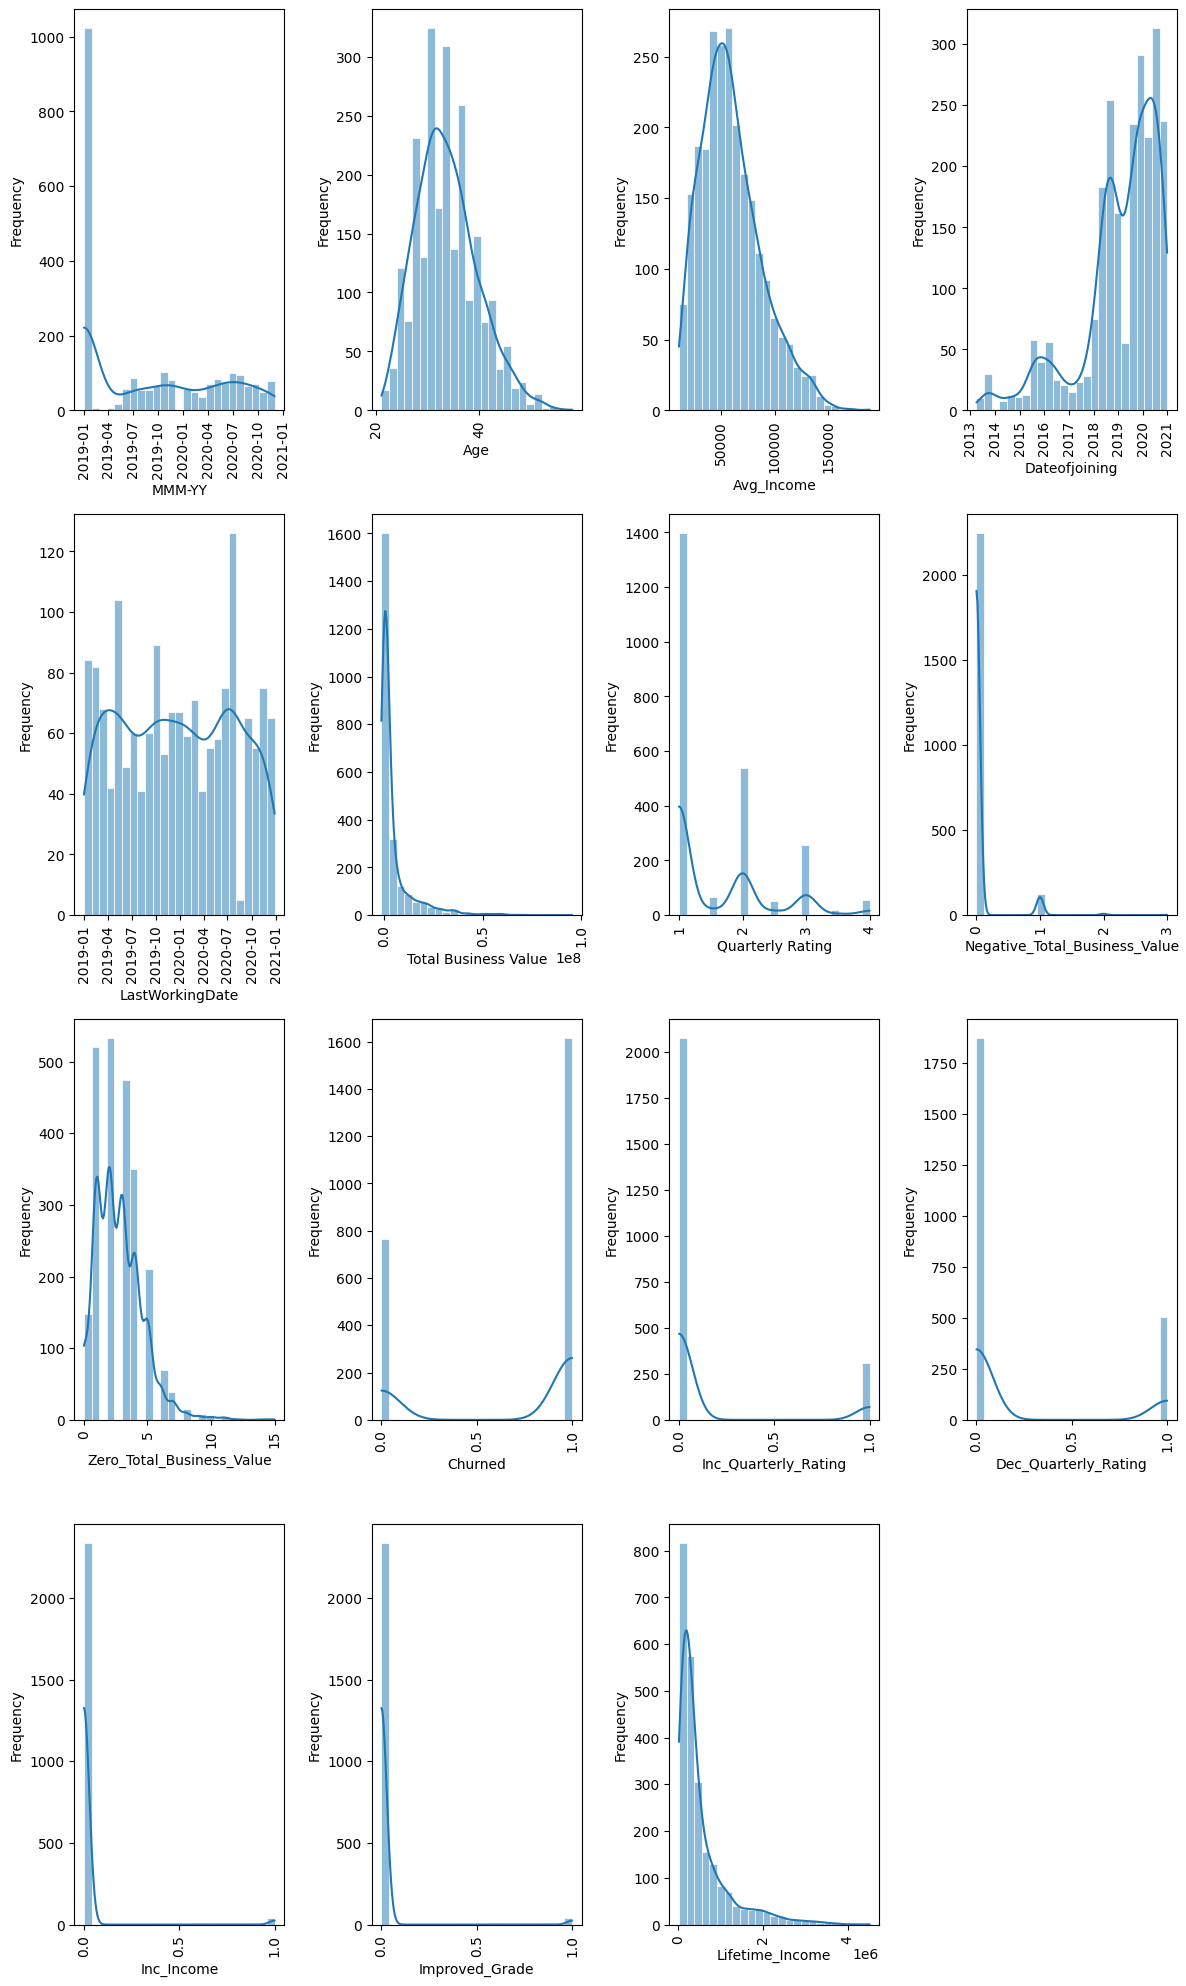

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12,20))
ax = ax.flatten()

for col in range(len(num_col[:-1])):
  sns.set(style='dark')
  sns.histplot(segment[num_col[col]], ax=ax[col], kde=True, bins=25)
  #ax[col].set_title(f"Distribution of {num_col[col]}")
  ax[col].set_xlabel(num_col[col])
  ax[col].set_ylabel('Frequency')
  ax[col].tick_params(axis='x', rotation=90)

for col in range(len(num_col[:-1]), len(ax)):
  ax[col].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

### Insights:
- All features ie `MMM-YY, Age, Avg_Income, Dateofjoining, Zero_Total_Business_Value, Churned, Inc_Quarterly_Rating, Dec_Quarterly_Rating, LastWorkingDate, Total_Business_Value, Quarterly_Rating, Negative_Total_Business_Value, Inc_Income, Improved_Grade`, and `Lifetime_Income` exhibit a skewed distribution.
- The data for `MMM-YY` and `Dateofjoining` appears to be heavily concentrated towards the recent years, while `Age` and `Avg_Income` seem to be more evenly distributed.
- The data for `LastWorkingDate` appears to be concentrated towards the recent years.
- The data for `Total_Business_Value` and `Quarterly_Rating` seems to be more evenly distributed.
- The data for `Zero_Total_Business_Value` and `Churned` appears to be heavily concentrated towards the lower end of the range, while `Inc_Quarterly_Rating` and `Dec_Quarterly_Rating` seem to be more evenly distributed.
- The data for `Inc_Income` and `Improved_Grade` appears to be heavily concentrated towards the lower end of the range, while `Lifetime_Income` seems to be more evenly distributed.

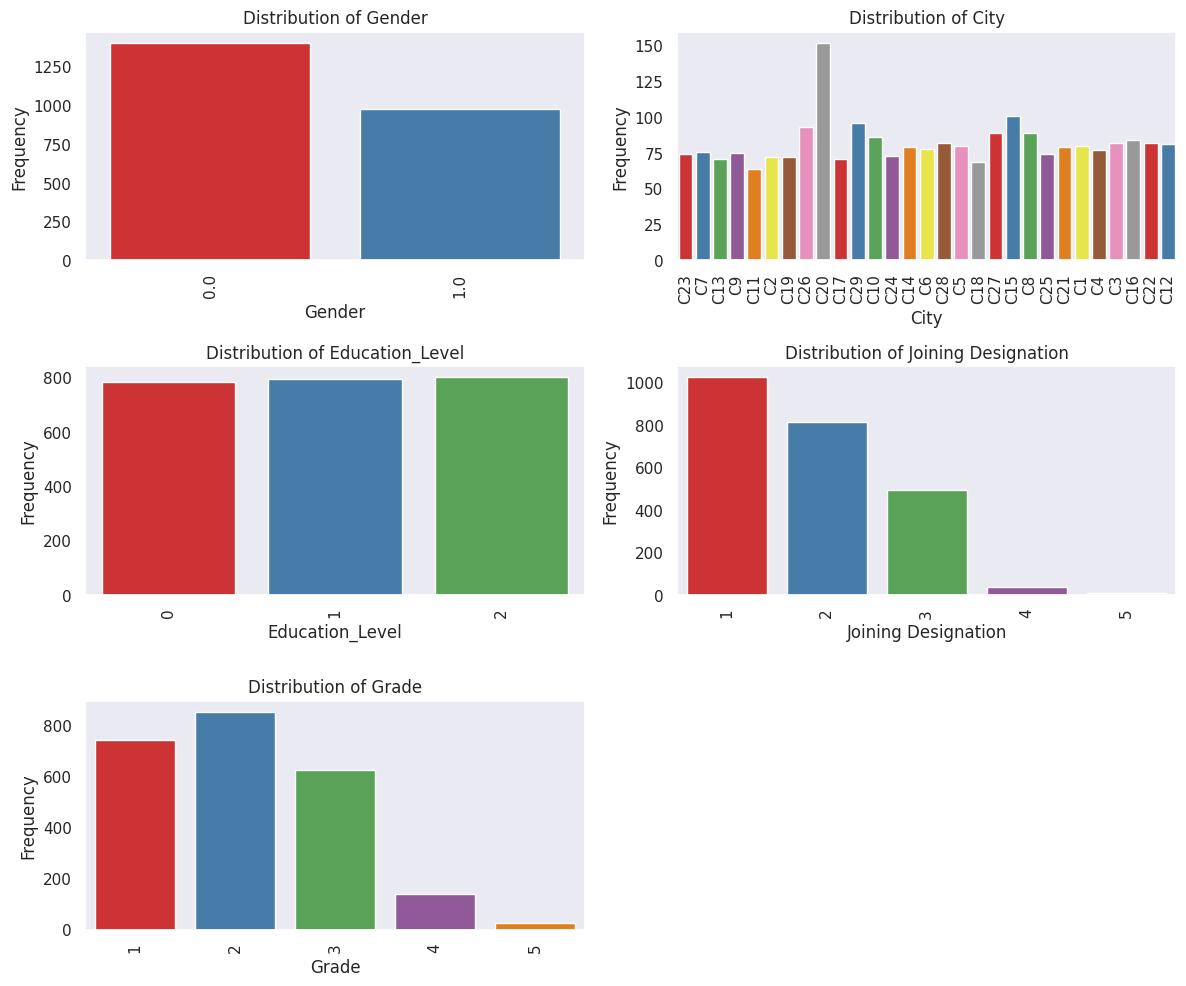

In [ ]:
seg_col = seg_cat_col[1:]
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
ax = ax.flatten()

for col in range(len(seg_col)):
  sns.countplot(data=segment, x=segment[seg_col[col]], ax=ax[col], palette='Set1')
  ax[col].set_title(f"Distribution of {seg_col[col]}")
  ax[col].set_xlabel(seg_col[col])
  ax[col].set_ylabel('Frequency')
  ax[col].tick_params(axis='x', rotation=90)

for col in range(len(seg_col), len(ax)):
  ax[col].set_visible(False)
plt.tight_layout(pad=1)
plt.show()

### Insights:
- **Dominant Gender**: The graph shows a clear majority of one gender (likely male) compared to the other. This indicates a potential gender imbalance in the dataset.
- **Diverse Locations**: The graph shows a wide range of cities represented in the dataset. This suggests a diverse customer base spread across different locations.
- **Distribution of Education Level**: The graph shows a relatively even distribution across three education levels. This suggests that the company has a diverse workforce with employees from different educational backgrounds.
- **Distribution of Joining Designation**: The graph shows a higher concentration of employees joining at lower designations. This indicates that the company may have a hierarchical structure with a larger base of entry-level employees.

## Bivariate Analysis:

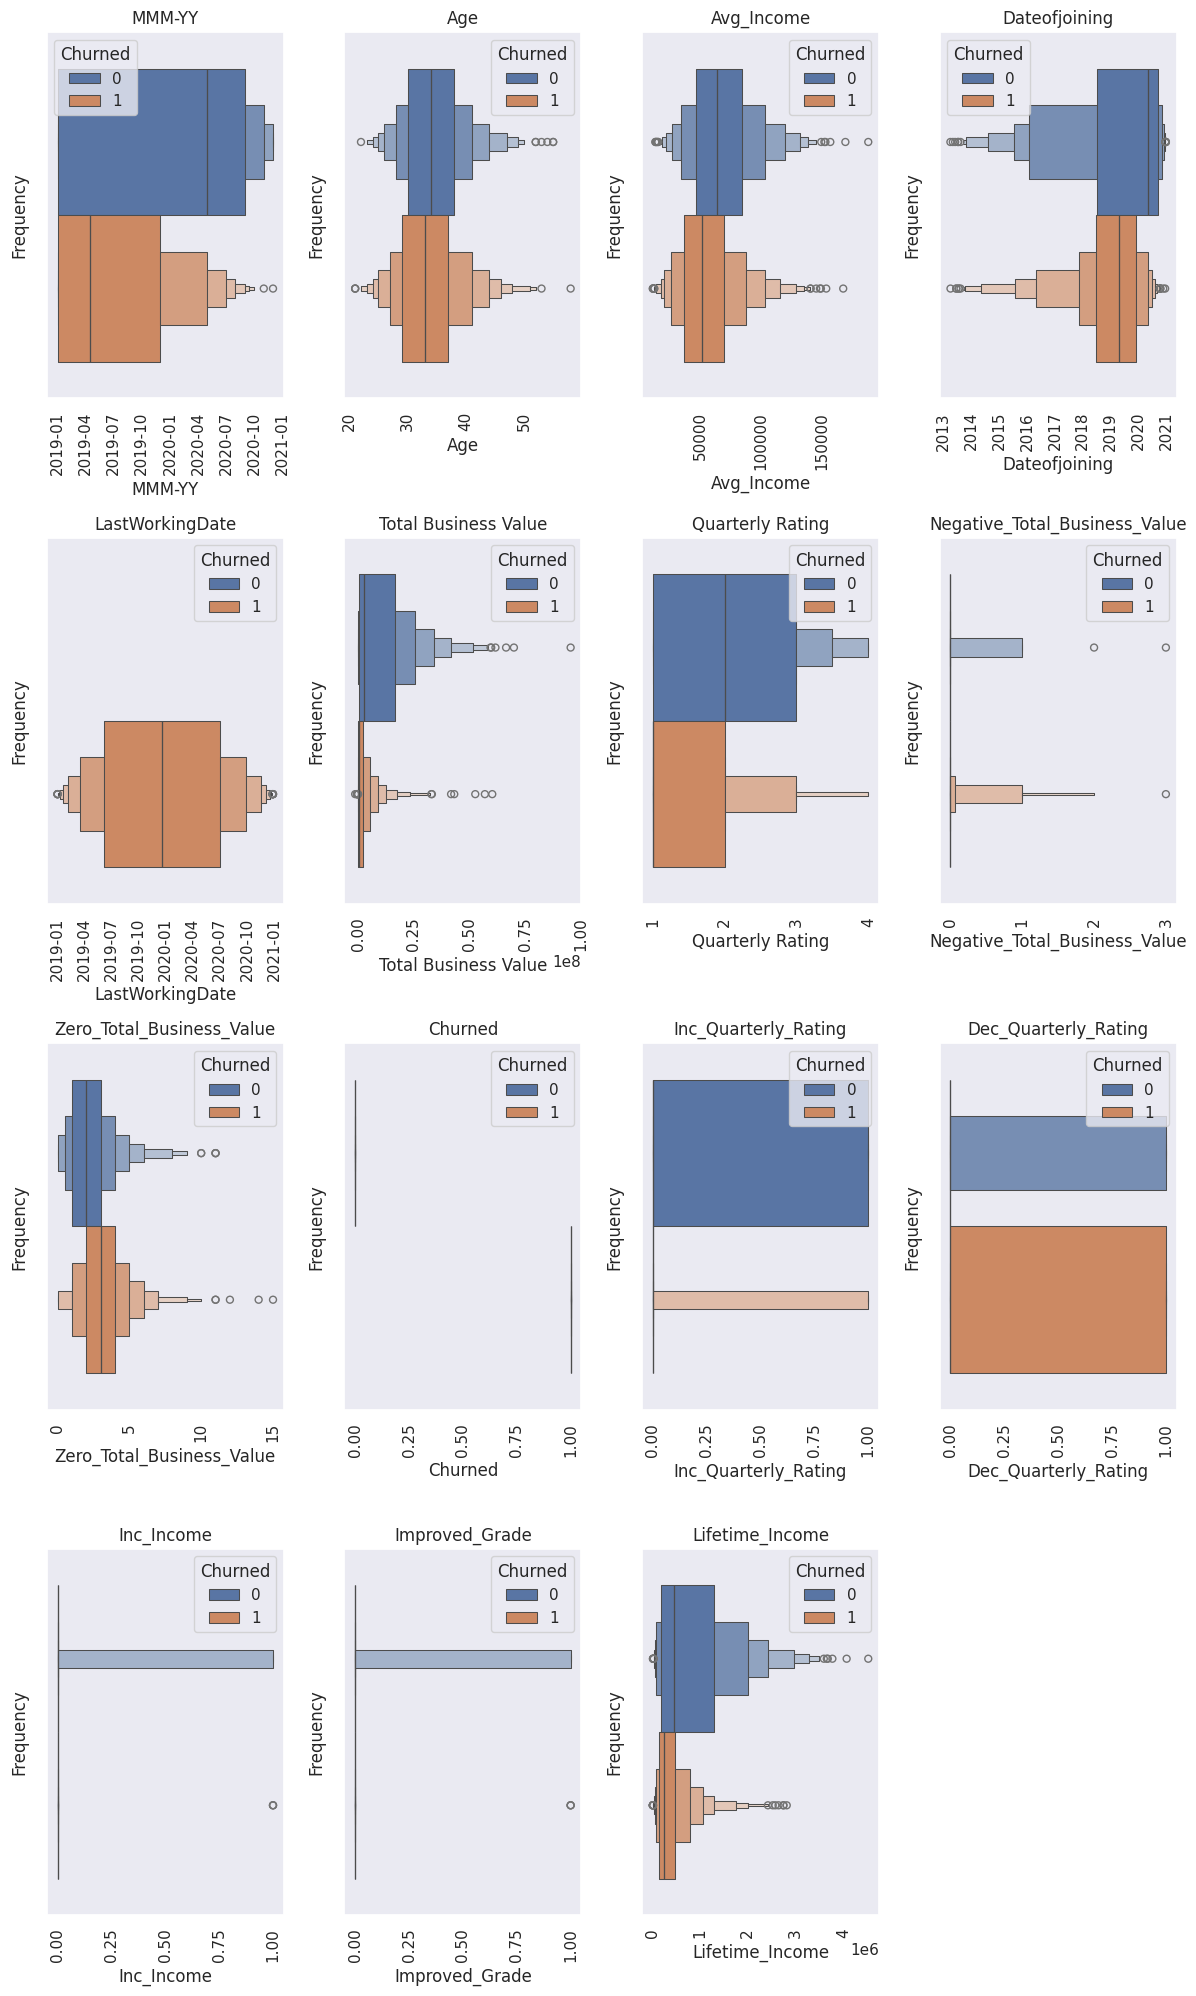

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12,20))
ax = ax.flatten()

for col in range(len(num_col[:-1])):
  sns.set(style='dark')
  sns.boxenplot(data=segment, x=segment[num_col[col]], hue='Churned', ax=ax[col])
  ax[col].set_title(num_col[col])
  #ax[col].set_xlabel(num_col[col])
  ax[col].set_ylabel('Frequency')
  ax[col].tick_params(axis='x', rotation=90)

for col in range(len(num_col[:-1]), len(ax)):
  ax[col].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

- MMM-YY:

  - **Observation**: The distribution of churned and non-churned customers seems to be relatively similar across different time periods.
  - **Insight**: This suggests that churn is not significantly influenced by the specific time period.
- Age:

  - **Observation**: Younger drivers seem to have a slightly higher churn rate compared to older drivers.
  - **Insight**:
    - Incentive Programs: Consider implementing targeted incentive programs to retain younger drivers, especially those who are new to the platform.
    - Flexible Work Hours: Offer flexible work hours to accommodate the lifestyle preferences of younger drivers.
- Avg_Income:

  - **Observation**: Drivers with lower average incomes appear to have a higher churn rate.
  - **Insight**:
    - Incentive Structure: Review the incentive structure to ensure fair compensation for all drivers, especially those with lower earnings.
    - Additional Income Streams: Explore opportunities to provide additional income streams to drivers, such as delivery or other services.
- Dateofjoining:

  - **Observation**: Drivers who joined recently seem to have a higher churn rate.
  - **Insight**:
    - Onboarding Experience: Improve the onboarding process for new drivers to ensure a smooth transition.
    - Mentorship Programs: Implement mentorship programs to help new drivers adapt to the platform and build relationships with experienced drivers.
- Total_Business_Value:

  - **Observation**: Drivers with higher total business values are less likely to churn.
  - **Insight**:
    - Incentive Structure: Design incentive structures that reward high-performing drivers to motivate them and reduce churn.
    - Support and Assistance: Provide additional support and assistance to drivers who are facing challenges in generating business.
- Negative_Total_Business_Value:

  - **Observation**: Drivers with higher negative total business values are more likely to churn.
  - **Insight**:
    - Performance Management: Implement a robust performance management system to identify and address issues with low-performing drivers.
    - Training and Support: Provide additional training and support to drivers with high negative business values to help them improve their performance.
- Inc_Income:

  - **Observation**: The distribution of churned and non-churned drivers is relatively similar across different income increase levels.
  - **Insight**: While income increase might be a positive factor, it alone does not seem to be a strong predictor of churn.
- Improved_Grade:

  - **Observation**: The distribution of churned and non-churned drivers is relatively similar for both improved and not improved grades.
  - **Insight**: Improving the driver's rating might not be a significant factor in preventing churn.
- Lifetime_Income:

  - **Observation**: Drivers with higher lifetime income are less likely to churn.
  - **Insight**:
    - Incentive Structure: Design incentive structures that reward long-term drivers to encourage loyalty.
    - Recognition and Rewards: Implement a system to recognize and reward top-performing drivers.

- Drivers with zero total business value and higher decrease in quarterly rating are more likely to churn whereas Drivers with a higher increase in quarterly rating are less likely to churn.


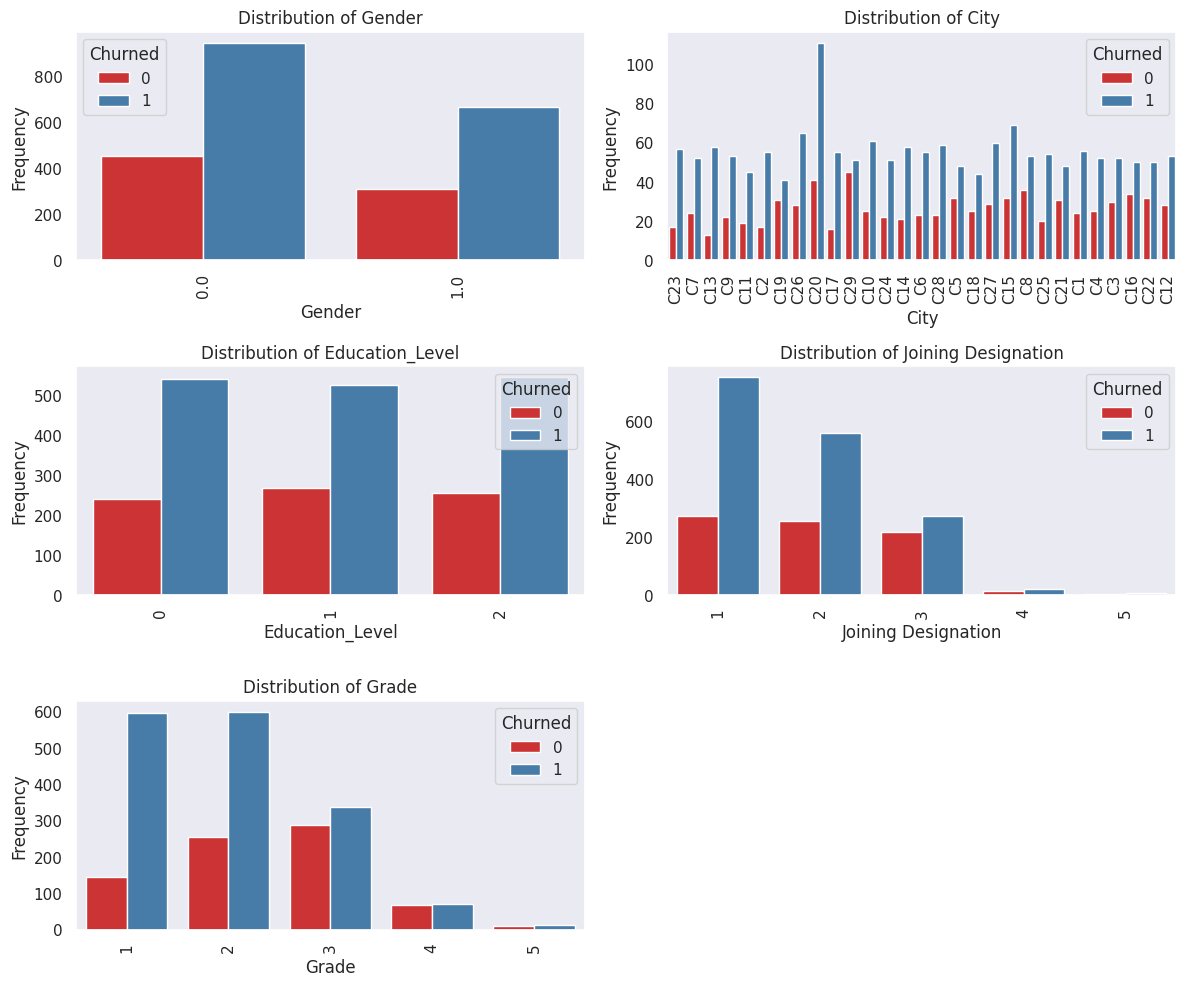

In [ ]:
seg_col = seg_cat_col[1:]
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
ax = ax.flatten()

for col in range(len(seg_col)):
  sns.countplot(data=segment, x=segment[seg_col[col]], ax=ax[col], palette='Set1', hue='Churned')
  ax[col].set_title(f"Distribution of {seg_col[col]}")
  ax[col].set_xlabel(seg_col[col])
  ax[col].set_ylabel('Frequency')
  ax[col].tick_params(axis='x', rotation=90)

for col in range(len(seg_col), len(ax)):
  ax[col].set_visible(False)
plt.tight_layout(pad=1)
plt.show()

### Insights:
- **Gender Disparity in Churn**: The graph indicates a higher proportion of customers of one gender (likely male) churning compared to the other. This suggests a potential gender-based disparity in customer satisfaction or retention.
- **City-Specific Churn**: The graph shows varying churn rates across different cities. This suggests that certain cities may have higher customer dissatisfaction or other factors contributing to churn.
- **Education Level and Churn**: The graph shows that churn rates are relatively similar across different education levels. This suggests that education level may not be a significant factor influencing customer churn.
- **Joining Designation and Churn**: The graph shows that churn rates tend to be higher for lower joining designations. This indicates that employees joining at lower levels may be more likely to churn.
- **Churn Rate Variation**: The churn rate appears to vary across different grades. While grades 1, 2, and 3 show a noticeable difference in churn rates, grades 4 and 5 have a much lower number of customers and thus, the churn rate might not be as significant.

## Multivariate Analysis:

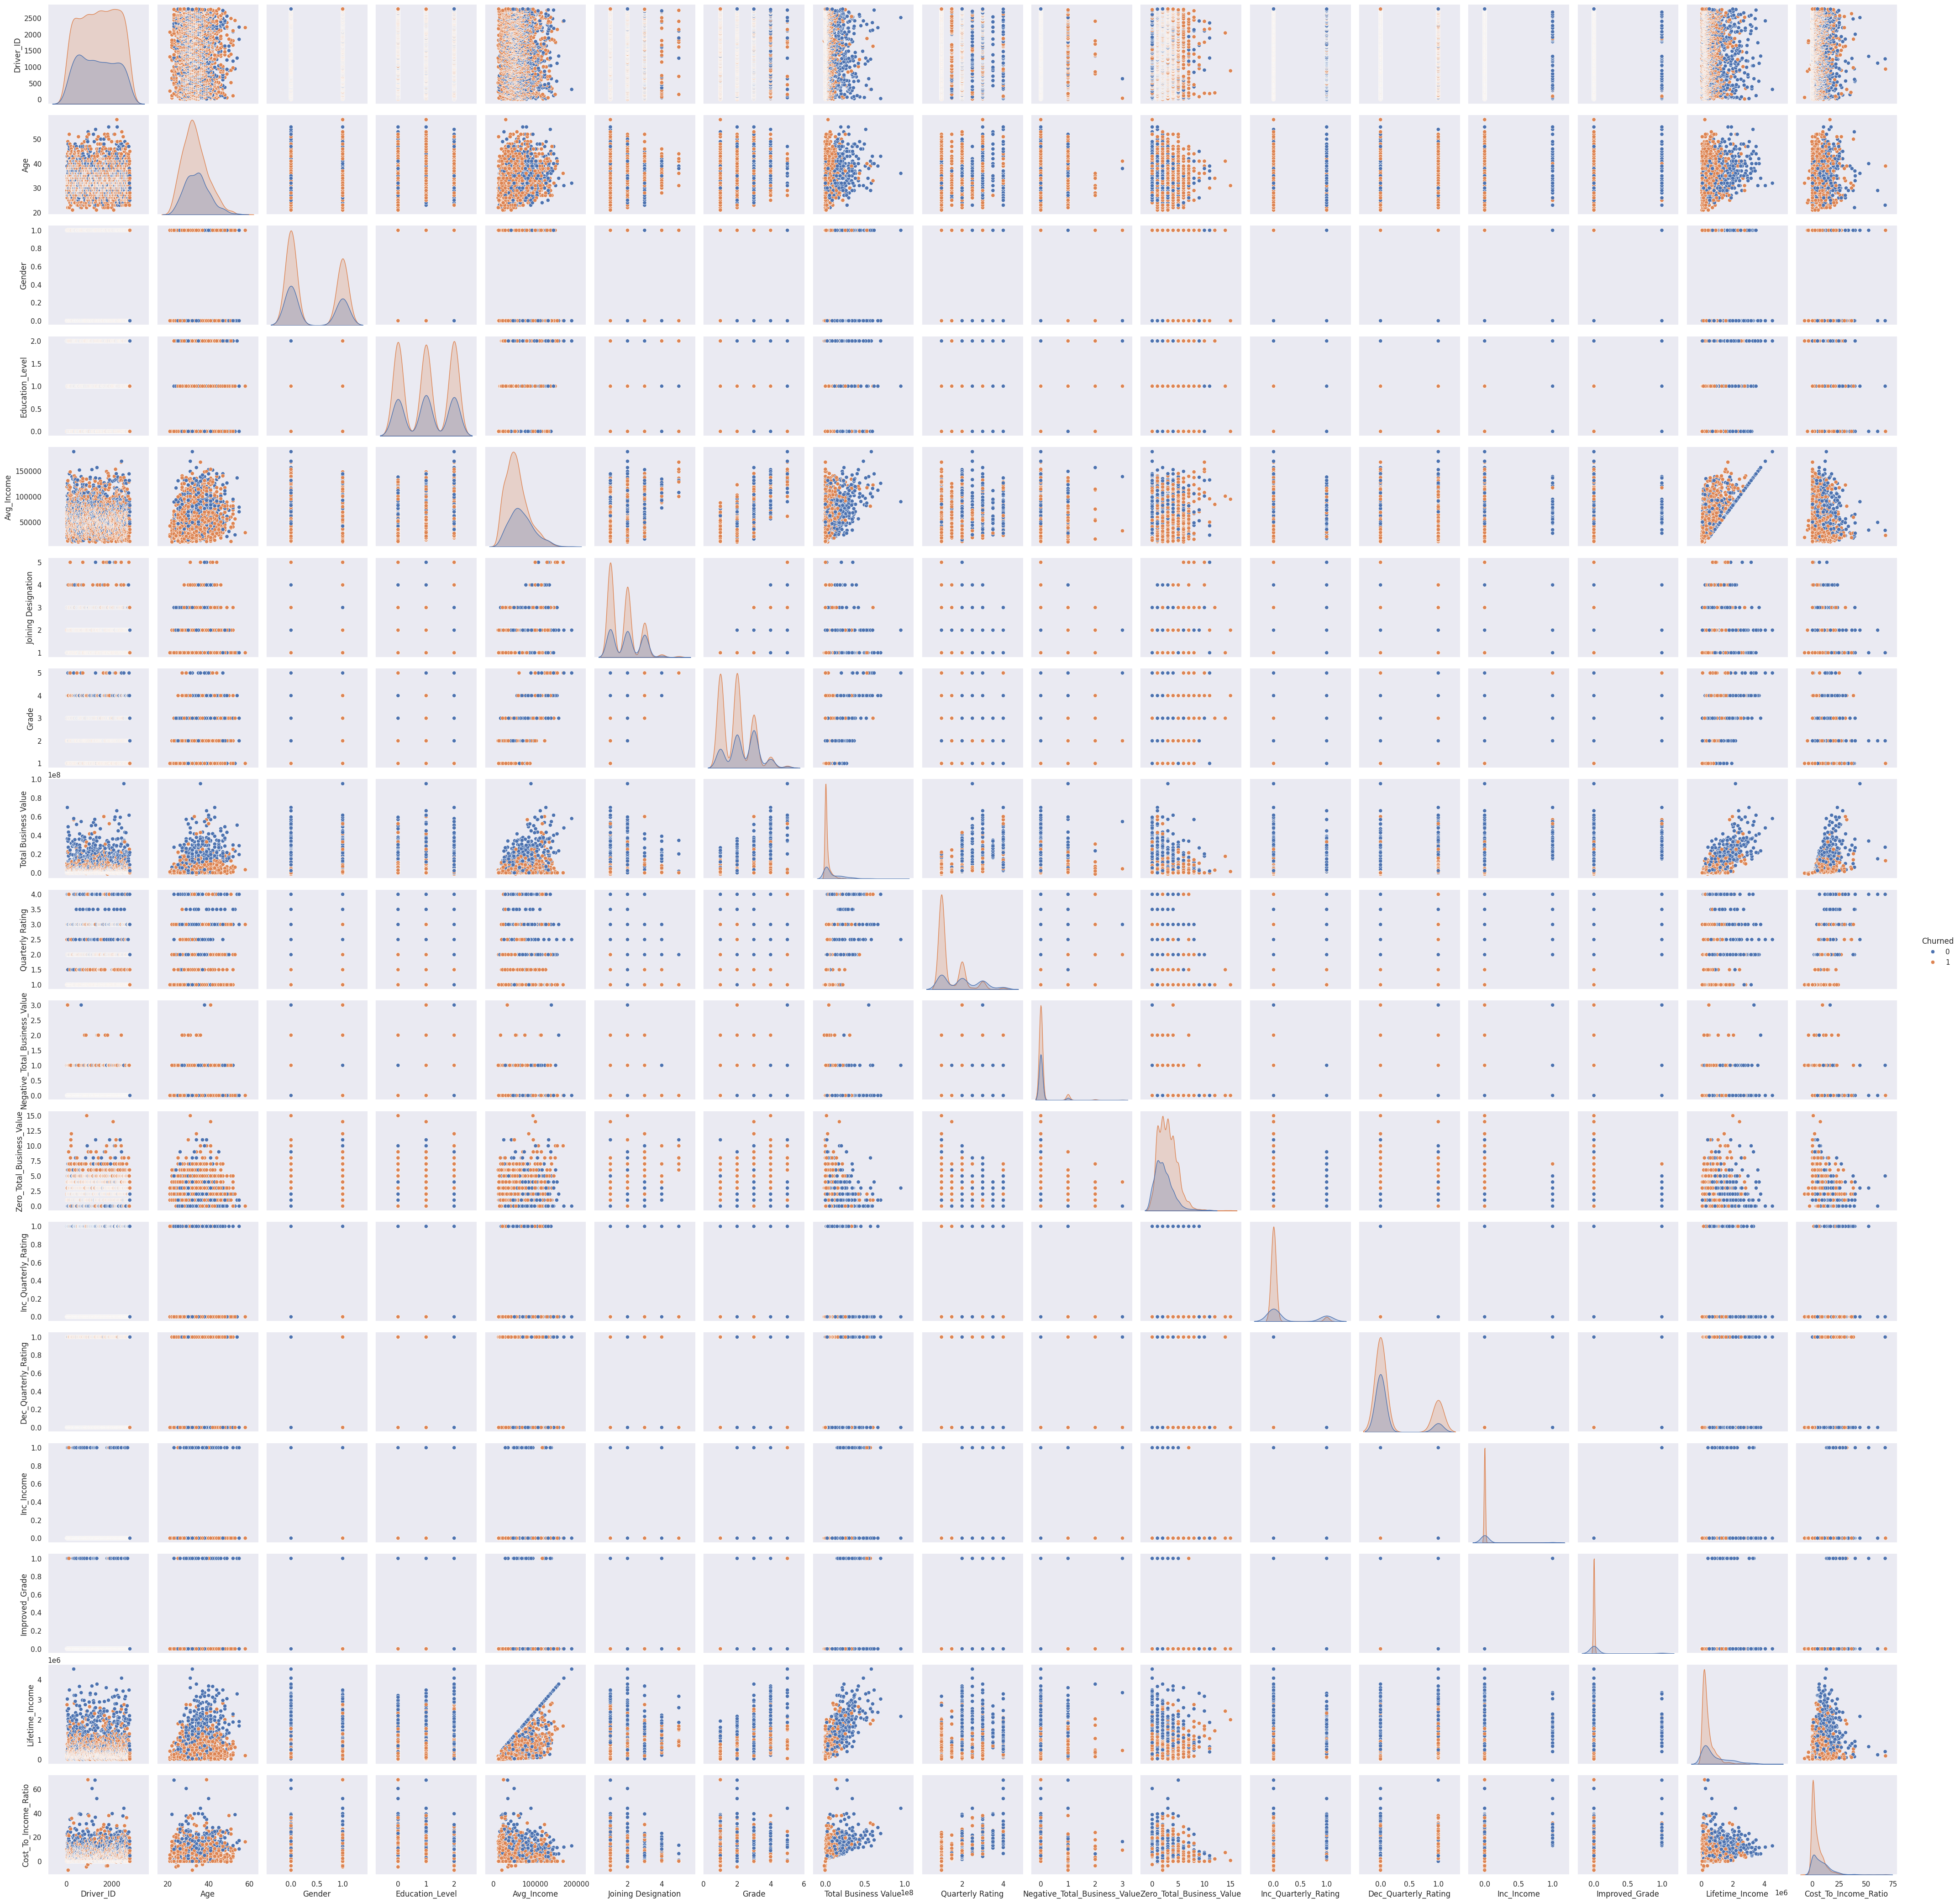

In [ ]:
sns.pairplot(segment, hue='Churned')
plt.show()

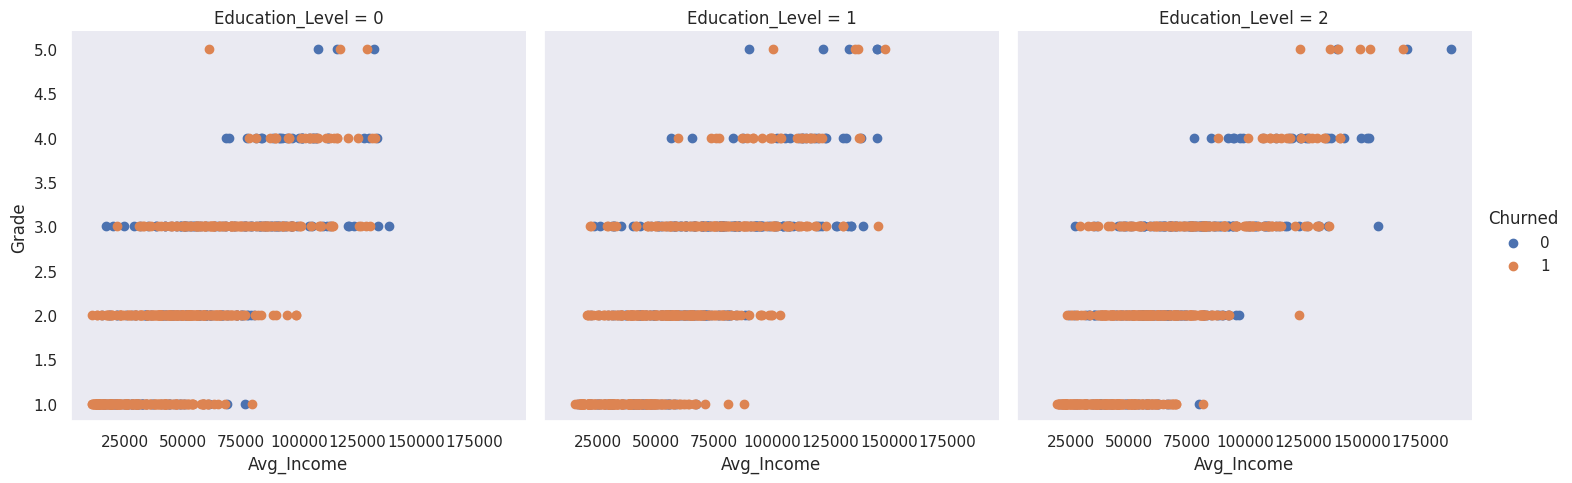

In [ ]:
graph = sns.FacetGrid(segment,col='Education_Level', hue='Churned', height=5)
graph.map(plt.scatter, 'Avg_Income', 'Grade').add_legend()
plt.show()

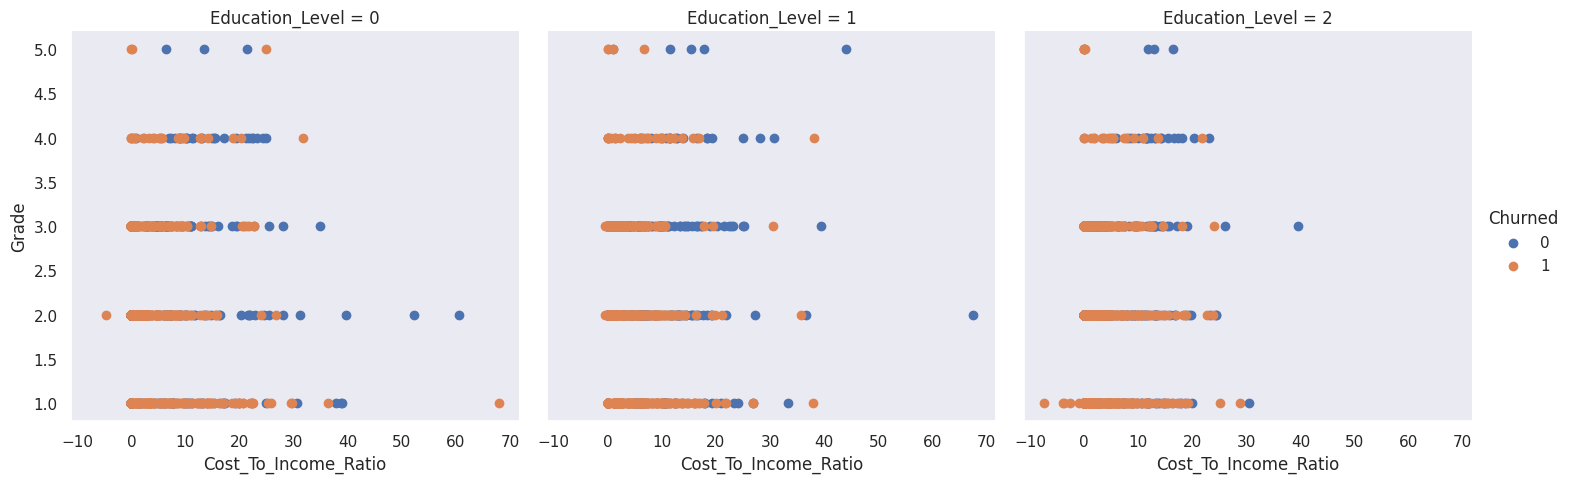

In [ ]:
graph = sns.FacetGrid(segment,col='Education_Level', hue='Churned', height=5)
graph.map(plt.scatter, 'Cost_To_Income_Ratio', 'Grade').add_legend()
plt.show()

### Observation:
- The graphs show that there is no clear pattern between education level, average income, and churn. Drivers across different education levels and income ranges have churned.

### Insights:
- Churn may be influenced by other factors.

### Correlation Map:

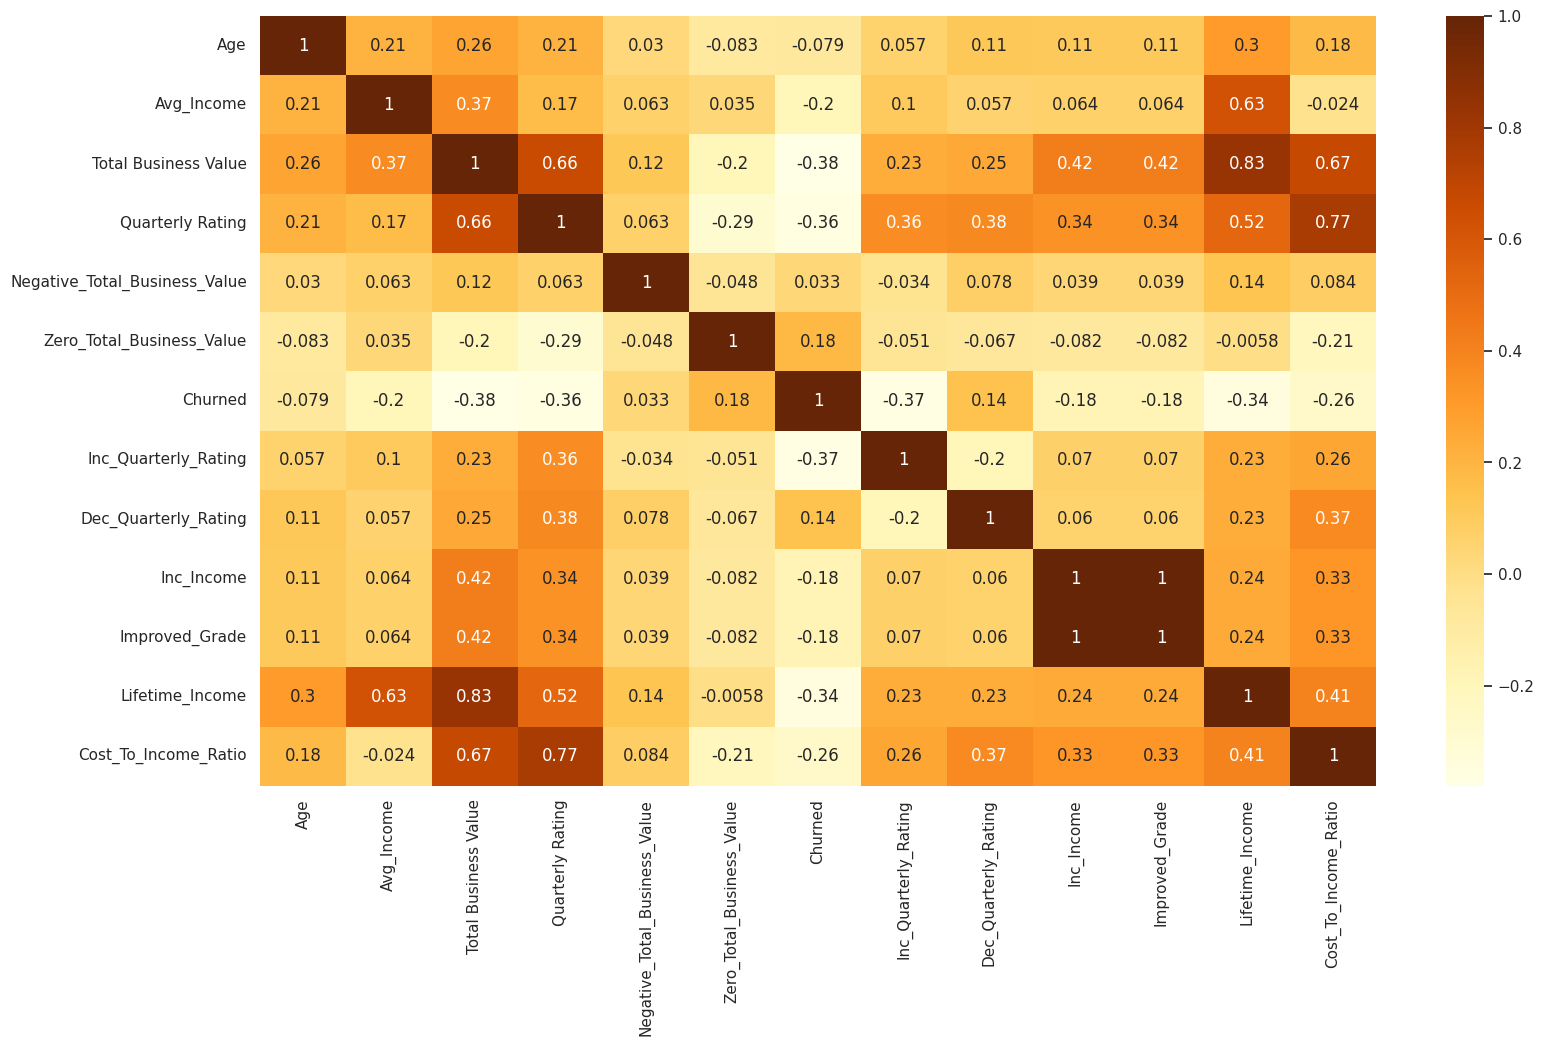

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(segment.corr(numeric_only=True), cmap = 'YlOrBr', annot = True)
plt.show()

### Insights:
- `Inc_Income` and `Imporved_Grade` closely tied (correlation = 1.000), suggesting that income increases are directly related to improved grading. hence we can drop any one of these.
- There's a strong positive correlation between `Total Business Value` and `Quarterly Rating` (0.6608), `Lifetime Income` (0.8276), and `Cost to Income Ratio` (0.6735). This indicates that higher business values often correspond with favorable quarterly ratings and income outcomes, though they are also associated with higher cost-to-income ratios.
- `Churned` has a strong negative correlation with `Total Business Value` (-0.3796), indicating that customers with higher business values are less likely to churn.
- `Quarterly Rating` and `Lifetime Income` also show moderate to strong negative correlations with `Churned` (-0.3574 and -0.3427, respectively).
- `Lifetime Income` has a high positive correlation with both `Avg_Income` (0.6267) and `Total Business Value` (0.8276), showing that these variables are closely linked to long-term revenue potential.
- There's a strong positive correlation between `Cost to Income Ratio` and `Quarterly Rating` (0.7736) as well as `Total Business Value` (0.6735). This suggests that while high-rated and high-value clients generate more income, they also come with higher associated costs.
- Negative `Total Business Value` has very low correlations with most metrics, but `Zero Total Business Value` shows a positive correlation with `Churned` (0.1835) and a negative correlation with `Quarterly Rating` (-0.2912).

In [ ]:
# droping the Inc_Income column due to high correlation.
segment.drop(columns=['Inc_Income'], inplace=True)

## Data Preprocessing:

In [ ]:
segment['City'] = segment['City'].str.strip('C').astype('int')
segment['Gender'] = segment['Gender'].astype('int')
segment['Education_Level'] = segment['Education_Level'].astype('int')
segment['Joining Designation'] = segment['Joining Designation'].astype('int')
segment['Grade'] = segment['Grade'].astype('int')
segment['Joining_Year'] = segment['Dateofjoining'].dt.year.astype('Int64')
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Driver_ID                      2381 non-null   object        
 1   MMM-YY                         2381 non-null   datetime64[ns]
 2   Age                            2381 non-null   float64       
 3   Gender                         2381 non-null   int64         
 4   City                           2381 non-null   int64         
 5   Education_Level                2381 non-null   int64         
 6   Avg_Income                     2381 non-null   float64       
 7   Dateofjoining                  2381 non-null   datetime64[ns]
 8   LastWorkingDate                1616 non-null   datetime64[ns]
 9   Joining Designation            2381 non-null   int64         
 10  Grade                          2381 non-null   int64         
 11  Total Business Va

In [ ]:
segment.isnull().sum()

Driver_ID                          0
MMM-YY                             0
Age                                0
Gender                             0
City                               0
Education_Level                    0
Avg_Income                         0
Dateofjoining                      0
LastWorkingDate                  765
Joining Designation                0
Grade                              0
Total Business Value               0
Quarterly Rating                   0
Negative_Total_Business_Value      0
Zero_Total_Business_Value          0
Churned                            0
Inc_Quarterly_Rating               0
Dec_Quarterly_Rating               0
Improved_Grade                     0
Lifetime_Income                    0
Cost_To_Income_Ratio               0
Joining_Year                       0
dtype: int64

In [ ]:
segment.duplicated().sum()

0

In [ ]:
X = segment.drop(columns=['Dateofjoining', 'LastWorkingDate', 'Driver_ID', 'MMM-YY', 'Churned'])
y = segment['Churned']
X.shape, y.shape

((2381, 17), (2381,))

In [ ]:
y.value_counts(normalize=True)

Churned
1    0.678706
0    0.321294
Name: proportion, dtype: float64

In [ ]:
# train test split with stratify to counter data imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1666, 17), (715, 17), (1666,), (715,))

In [ ]:
# scaling the data via standard scaler
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

## Model Creation:

### Random Forest Classifier Model:

In [ ]:
rf_model = RandomForestClassifier(n_estimators=150, min_samples_leaf=3, criterion='entropy', n_jobs=-1, random_state=99, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
train_pred = rf_model.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

Training Accuracy Score : 0.9603841536614646
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       230
           1       0.91      0.88      0.89       485

    accuracy                           0.86       715
   macro avg       0.84      0.84      0.84       715
weighted avg       0.86      0.86      0.86       715



In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

Feature  Importance
16               Joining_Year    0.219670
7        Total Business Value    0.141667
14            Lifetime_Income    0.130683
10  Zero_Total_Business_Value    0.071478
15       Cost_To_Income_Ratio    0.068252
4                  Avg_Income    0.067452
11       Inc_Quarterly_Rating    0.052400
8            Quarterly Rating    0.050176
2                        City    0.048951
0                         Age    0.045444

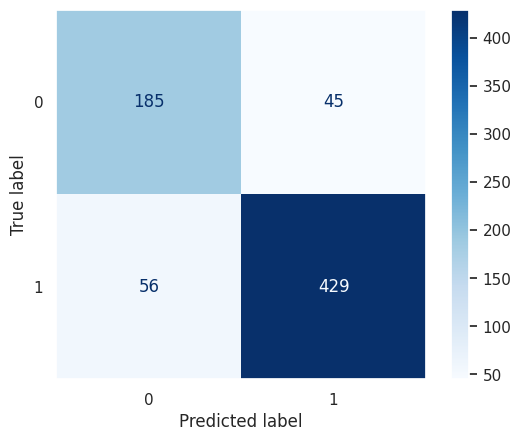

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= rf_model.classes_).plot(cmap='Blues')
plt.show()

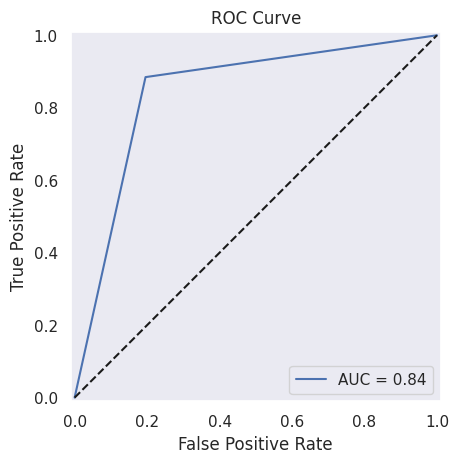

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()


### LightGBM Model:

In [ ]:
lgbm_classifier = lgb.LGBMClassifier(n_estimators=150, boosting_type='gbdt', learning_rate=0.02, random_state=99, class_weight='balanced')
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)
train_pred = lgbm_classifier.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1131, number of negative: 535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training Accuracy Score : 0.9321728691476591
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       230
           1       0.93      0.85      0.89       485

    accuracy                           0.86       715
   macro avg       0.84      0.86      0.84       715
weighted avg       0.87      0.86      0.86       715



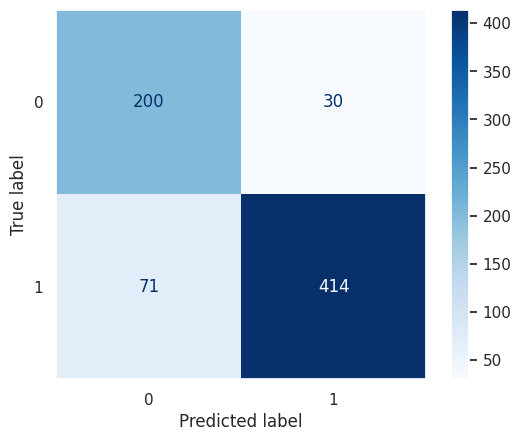

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= lgbm_classifier.classes_).plot(cmap='Blues')
plt.show()

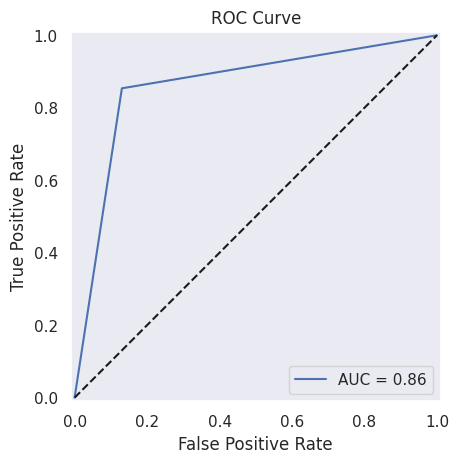

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': lgbm_classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

Feature  Importance
14            Lifetime_Income         696
4                  Avg_Income         669
7        Total Business Value         594
2                        City         492
10  Zero_Total_Business_Value         416
16               Joining_Year         372
0                         Age         354
15       Cost_To_Income_Ratio         244
11       Inc_Quarterly_Rating         142
12       Dec_Quarterly_Rating         137

### XGBoost Model:

In [ ]:
xgb_classifier = xgb.XGBClassifier( n_estimators=150, boosting_type='gbdt', learning_rate=0.02, random_state=99, class_weight='balanced')
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
train_pred = xgb_classifier.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

Training Accuracy Score : 0.9315726290516206
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       230
           1       0.89      0.92      0.91       485

    accuracy                           0.87       715
   macro avg       0.86      0.84      0.85       715
weighted avg       0.87      0.87      0.87       715



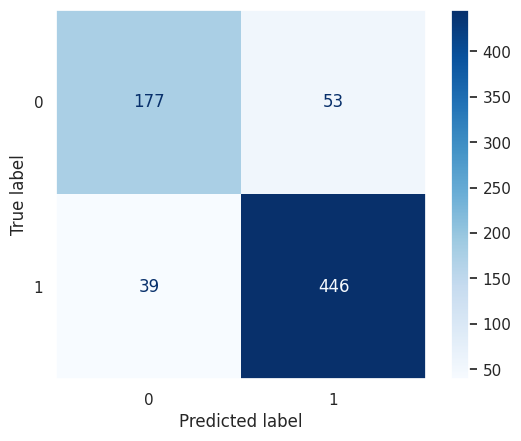

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= xgb_classifier.classes_).plot(cmap='Blues')
plt.show()

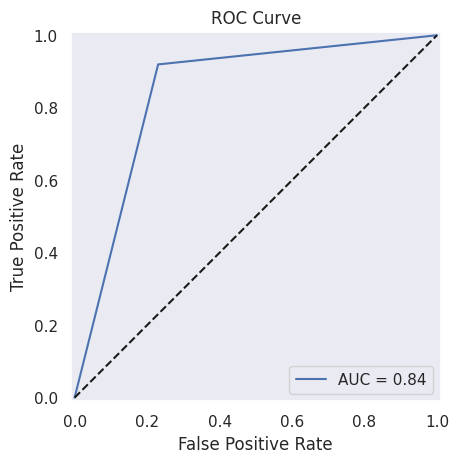

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

Feature  Importance
16                   Joining_Year    0.251160
11           Inc_Quarterly_Rating    0.199574
7            Total Business Value    0.151100
10      Zero_Total_Business_Value    0.091021
12           Dec_Quarterly_Rating    0.050535
9   Negative_Total_Business_Value    0.045853
15           Cost_To_Income_Ratio    0.029019
14                Lifetime_Income    0.027651
4                      Avg_Income    0.023137
6                           Grade    0.022945

### Gradient Boosting Model:

In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.131, random_state=99)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
train_pred = gb_classifier.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

Training Accuracy Score : 0.9141656662665066
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       230
           1       0.89      0.92      0.90       485

    accuracy                           0.87       715
   macro avg       0.85      0.84      0.85       715
weighted avg       0.87      0.87      0.87       715



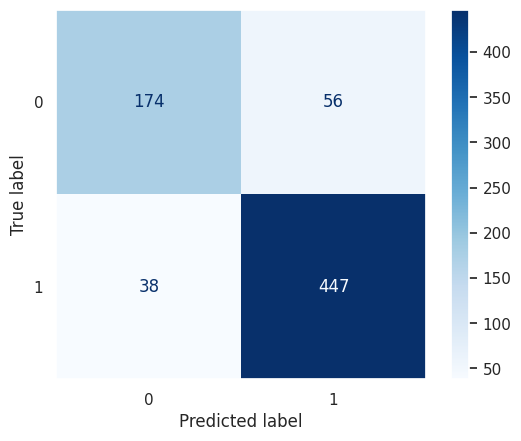

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= gb_classifier.classes_).plot(cmap='Blues')
plt.show()

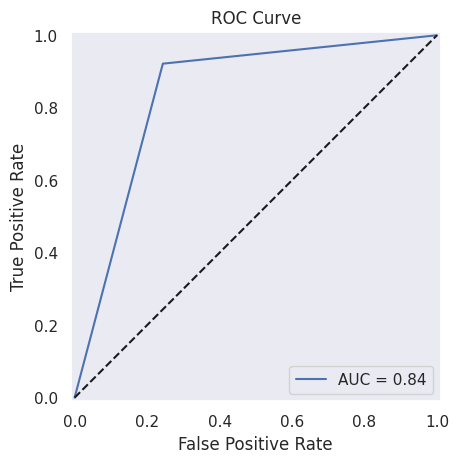

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': gb_classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

Feature  Importance
16               Joining_Year    0.347512
7        Total Business Value    0.277843
10  Zero_Total_Business_Value    0.111552
11       Inc_Quarterly_Rating    0.095647
14            Lifetime_Income    0.046236
12       Dec_Quarterly_Rating    0.035022
15       Cost_To_Income_Ratio    0.027541
4                  Avg_Income    0.018921
8            Quarterly Rating    0.017813
0                         Age    0.009087

### Adaptive Boosting Model:

In [ ]:
ada_classifier = AdaBoostClassifier(n_estimators=100, learning_rate=0.85, random_state=99)
ada_classifier.fit(X_train, y_train)
y_pred = ada_classifier.predict(X_test)
train_pred = ada_classifier.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

Training Accuracy Score : 0.8925570228091236
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       230
           1       0.88      0.92      0.90       485

    accuracy                           0.86       715
   macro avg       0.84      0.83      0.83       715
weighted avg       0.86      0.86      0.86       715



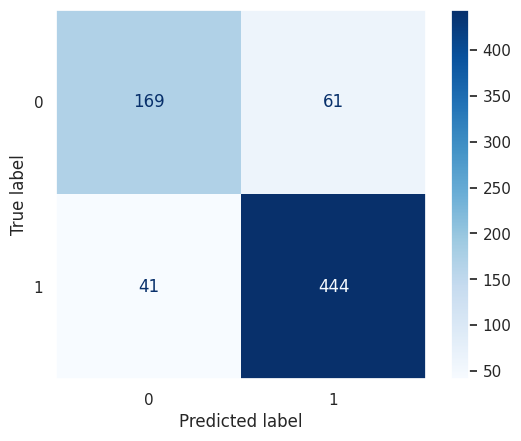

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= ada_classifier.classes_).plot(cmap='Blues')
plt.show()

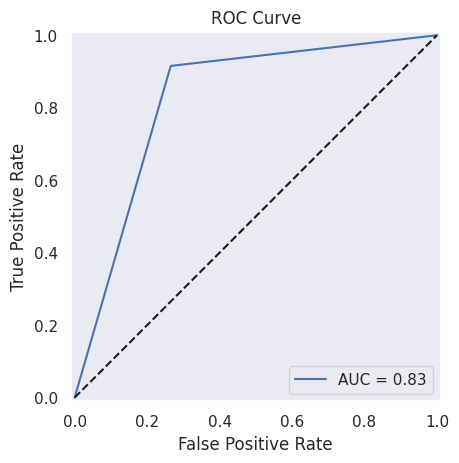

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': ada_classifier.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

Feature  Importance
14            Lifetime_Income        0.20
4                  Avg_Income        0.13
16               Joining_Year        0.12
7        Total Business Value        0.10
15       Cost_To_Income_Ratio        0.10
0                         Age        0.08
10  Zero_Total_Business_Value        0.07
12       Dec_Quarterly_Rating        0.04
2                        City        0.04
8            Quarterly Rating        0.04

### Voting Classifier Model:

In [ ]:
voting_classifier = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('lgbm', lgbm_classifier),
    ('xgb', xgb_classifier),
    ('gb', gb_classifier),
    ('ada', ada_classifier)],
    voting='hard')
voting_classifier.fit(X_train, y_train)
y_pred = voting_classifier.predict(X_test)
train_pred = voting_classifier.predict(X_train)
print(f'Training Accuracy Score : {accuracy_score(y_train, train_pred)}')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 1131, number of negative: 535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 1666, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training Accuracy Score : 0.929171668667467
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       230
           1       0.90      0.90      0.90       485

    accuracy                           0.86       715
   macro avg       0.84      0.84      0.84       715
weighted avg       0.86      0.86      0.86       715



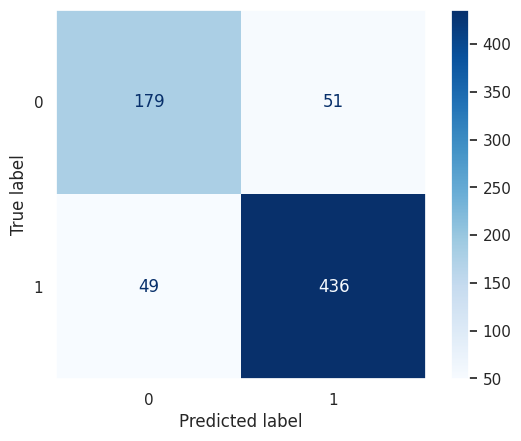

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= voting_classifier.classes_).plot(cmap='Blues')
plt.show()

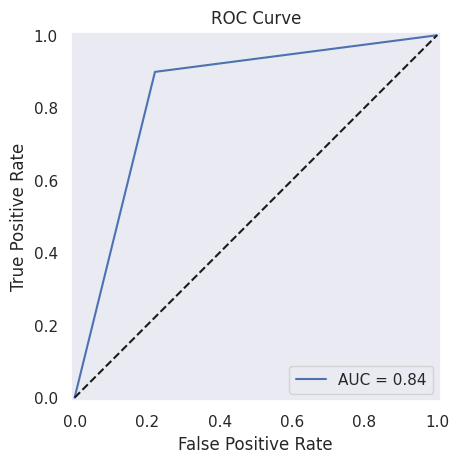

In [ ]:
#ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

## **Model Performance:**

Each model (Random Forest Classifier, LightGBM, XGBoost, Gradient Boost, Adaptive Boost, and Voting Classifier) achieves relatively high accuracy scores ranging from 86% to 87% for predicting churn.

**Churn Prediction Metrics:**

* Precision: The precision measures the proportion of correctly predicted churn cases among all predicted churn cases. It ranges from 88% to 93% for predicting churn, indicating the models' ability to avoid false positives.
* Recall: The recall measures the proportion of correctly predicted churn cases among all actual churn cases. It ranges from 85% to 92%, indicating the models' ability to identify actual churn cases.
* F1 Score: The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. It ranges from 89% to 91%.
* ROC AUC: The ROC AUC (Area Under the Receiver Operating Characteristic Curve) measures the models' ability to distinguish between churn and non-churn instances. It ranges from 83% to 86%, indicating good performance in classifying instances.

**Comparison Across Models:**

Adaptive Boost and Voting Classifier consistently achieve the highest accuracy score, precision, recall, F1 score, and ROC AUC among the models considered.
Random Forest Classifier, LightGBM, XGBoost, and Gradient Boost also perform well but have slightly lower performance metrics compared to Adaptive Boost and Voting Classifier.


**Model Comparison:**

* Adaptive Boost and the Voting Classifier stands out as the best-performing model overall, with consistently high scores across all metrics for both predicting churn and non-churn.

## Insights and Recommendations:


### Performance Metrics

* Based on the performance metrics, the OLA may consider using Adaptive Boost as the primary model for churn prediction, as it achieves the highest scores across most evaluation metrics.
* Additionally, RandomForestClassifier, Gradient Boost, and the Voting Classifier are suitable alternatives, offering competitive performance for churn prediction.

### Feature Importance: Strong predictors for churn
- Lifetime_Income
- Avg_Income
-	Joining_Year
-	Total Business Value
-	Cost_To_Income_Ratio
-	Age
-	Zero_Total_Business_Value
-	Dec_Quarterly_Rating
-	City
- Rating

### Recommendation:
Based on the feature importance analysis, OLA may prioritize strategies and interventions aimed at improving total business value, retaining drivers who joined in earlier years, and managing quarterly ratings effectively.

## Questionnaire:

**1. What percentage of drivers have received a quarterly rating of 5?**
  * None of the drivers in the given data set have recieved a Quarterly rating of 5.0.
  

**2. Comment on the correlation between Age and Quarterly Rating.**
  * ***Weak Positive Correlation:*** The correlation coefficient of 0.23 indicates a weak positive linear relationship between Age and Quarterly Rating. As the value is positive, it suggests that as Age increases, there tends to be a slight increase in Quarterly Rating on average.

**3. Name the city which showed the most improvement in Quarterly Rating over the past year.**
  * C3 and C21 showed the most improvement in Quarterly Rating over the past year.

**4. Drivers with a Grade of ‘A’ are more likely to have a higher Total Business Value. (T/F)**
  * False. A higher total business value is more likely to be associated with drivers having a higher grade but not vice versa. It can be visualized from the graph density of the drivers for all grades is more towards the low total business value however the maximum total business value increases with the increase in grade.

**5. If a driver's Quarterly Rating drops significantly, how does it impact their Total Business Value in the subsequent period?**
  * If a driver's Quarterly Rating drops significantly, the Total Business Value also drops significantly for the driver.

**6. From Ola's perspective, which metric should be the primary focus for driver retention?**
* **ROC AUC**
* **Precision**
* **Recall**
* **F1 Score**

* In scenarios where the consequences of false negatives (predicting a driver will not churn but they actually do) outweigh those of false positives (predicting a driver will churn but they do not), maximizing Recall may indeed be more appropriate.
* Maximizing Recall would prioritize identifying all potentially churn-prone drivers, even if it means some false positives occur. This approach aims to minimize the risk of missing drivers who are genuinely at risk of leaving the platform.

**7. How does the gap in precision and recall affect Ola's relationship with its drivers and customers?**
* The gap between precision and recall can have significant impact on Ola's relationship with its drivers and customers:

  **Driver Relationship:**

  **High Precision, Low Recall:** If Ola prioritizes precision over recall, it means that the company is focusing on accurately identifying drivers who meet certain criteria (e.g., high-performance drivers, drivers with positive customer ratings). This can lead to better driver satisfaction as it ensures that drivers who receive incentives, rewards, or recognition truly deserve it based on their performance. However, it may also result in missing out on some deserving drivers who might be overlooked due to the stringent criteria, potentially leading to dissatisfaction among those drivers.

  **Low Precision, High Recall:** Conversely, if Ola prioritizes recall over precision, it means that the company is casting a wider net to include a larger number of drivers who meet certain criteria. While this approach may ensure that deserving drivers are not overlooked, it may also lead to rewarding drivers who do not truly deserve it, potentially causing dissatisfaction among drivers who feel that rewards are being distributed unfairly.

  **Customer Relationship:**

  **High Precision, Low Recall:** A high precision means that Ola's algorithms accurately identify and recommend drivers who provide exceptional service, leading to higher customer satisfaction. Customers are more likely to receive a reliable and high-quality service when matched with drivers who have a proven track record of performance. However, if the recall is low, it means that Ola may miss out on recommending some high-quality drivers, leading to potential dissatisfaction among customers who receive subpar service from drivers who were not identified by the algorithm.

  **Low Precision, High Recall:** A focus on high recall ensures that Ola's algorithms cast a wider net to include a larger pool of drivers, increasing the chances of matching customers with available drivers. While this approach may lead to more reliable service availability, it also increases the likelihood of recommending drivers who may not provide the best service quality. This could result in customer dissatisfaction if they have negative experiences with drivers who were recommended by the algorithm based on high recall but do not meet the expected service standards.

  In summary, the gap between precision and recall can influence Ola's relationship with its drivers and customers by impacting the fairness of rewards and incentives for drivers, as well as the quality and reliability of service for customers. Ola must strike the right balance between precision and recall to ensure a positive experience for both drivers and customers.

**8. Besides the obvious features like "Number of Rides", which lesser-discussed features might have a strong impact on a driver's Quarterly Rating?**
The below features might have a strong impact on a driver's Quarterly Rating
* Response Time
* Route Efficiency
* Vehicle Cleanliness and Maintenance
* Communication Skills
* Safety and Driving Behavior
* Personalization and Customer Service

**9. Will the driver's performance be affected by the City they operate in? (Yes/No)**
* No. The driver's performance is not affected by the City they operate in as it can be inferred from the box plot that all the cities share a similar range of Quarterly Rating among it's drivers.

**10. Analyze any seasonality in the driver's ratings. Do certain times of the year correspond to higher or lower ratings, and why might that be?**
* Not much seasonality is seen in the driver's ratings however in the months of 'July,' 'August' and 'September' for both the years 2019 and 2020 there is a decline than usual in the 2.0 Quarterly Rating of the driver's.
